Keong Jo Hsi 1001685  
Homework 5 Coding Part 2: RNN For Classification with LSTM

Required files which are not included:
- name dataset accessible as `/data/names/`

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random
import copy
from torch.utils.data import Dataset, DataLoader
import unicodedata
import string

In [3]:
def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Partition data
def partition(data, ratio=0.3):
    shuffled = random.sample(data, k=len(data))
    split_idx = int(len(shuffled)*0.3)
    return shuffled[:split_idx], shuffled[split_idx:]

for filename in findFiles('data/names/*.txt'):
    filename_norm = os.path.normpath(filename)
#     print(filename_norm)
    category = filename_norm.split('\\')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename_norm)
#     print(lines)
    category_lines[category] = partition(lines)

n_categories = len(all_categories)

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

# print(letterToTensor('J'))
# print(lineToTensor('Jones').shape)

In [5]:
# category-index mapping
category_index = {c:i for i, c in enumerate(all_categories)}
    
class WordDataset(Dataset):
    def __init__(self, wordnamelist, train_test_idx):
        self.word_cat_list = []
        
        for cat, words in category_lines.items():
            for word in words[train_test_idx]:
                name = lineToTensor(word)
                category = torch.tensor([category_index[cat]])
                self.word_cat_list.append((name, category))
                
        random.shuffle(self.word_cat_list)
        
    def __getitem__(self, index):
        word, cat = self.word_cat_list[index]
#         print('category', cat.shape, '\n' 'word', word.shape)
        return word, cat
        
    def __len__(self):
        return len(self.word_cat_list)
    

In [6]:
device = torch.device('cuda:0')

In [7]:
def collate(batch):
    # batch = [(tensor, label), (tensor, label),...]
    # sort batch in descending order of tensor sequence length
    sorted_batch = sorted(batch, key=lambda x:x[0].shape[0], reverse=True)
    
    # sends each (tensor, label) in sorted batch into zip
    tensor, label = zip(*sorted_batch)
    
#     print('label', label[0].shape)
    return torch.nn.utils.rnn.pack_sequence(tensor), torch.cat(label)


In [8]:
import torch.nn as nn

class LSTMmodel(nn.Module):    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, device):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size=input_size,
                     hidden_size=hidden_size,
                     num_layers = num_layers
                    )
        self.fc = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
#         print('x','\n',x)
        # x is PackedSequence
        h_0 = torch.zeros((self.num_layers, x.batch_sizes[0], self.hidden_size), device=self.device)
        c_0 = torch.zeros((self.num_layers, x.batch_sizes[0], self.hidden_size), device=self.device)
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        output = self.fc(h_n[-1,:,:])
        return output


In [9]:
def train(model, train_dataloader, test_dataloader, train_data_len, device=device):
    model = model.to(device)
    cross_entropy = nn.CrossEntropyLoss(size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    total_iter = train_data_len / train_dataloader.batch_size
    stats = []
    saved_epoch = 0
    
    for epoch in range(1,6):
        running_loss = 0
        totals = 0
        iteration = 0
        model.train()      
        
        for packedseq, label in train_dataloader:
            if device.type == 'cuda':
                packedseq = packedseq.cuda()
            elif device.type == "cpu":
                packedseq = packedseq.cpu()
            label = label.to(device)
            
            iteration += 1
            
            optimizer.zero_grad()
            output = model(packedseq)
            
            loss = cross_entropy(output, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            totals += label.shape[0]
            
            print('iter: {}/{}, running loss = {:.4f}'.format(iteration, total_iter, running_loss), end='\r')
            
        training_loss = running_loss / totals
        test_loss, test_acc = test(model, test_dataloader, device=device)
        stats.append((training_loss, test_loss, test_acc))
                   
        if test_acc > best_acc:
            best_acc = test_acc
            saved_epoch = epoch
            best_model_weights = copy.deepcopy(model.state_dict())
            
        print('Epoch: {} \tTraining Loss: {:.4f} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f}'.format(
               epoch, training_loss, test_loss, test_acc))
        
    print('Best Test Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_weights)
    
    return stats, saved_epoch

In [10]:
def test(model, dataloader, device=device):
    cross_entropy = nn.CrossEntropyLoss(size_average=False)
    model = model.to(device)
    model.eval()
    
    total_loss = 0
    total_corrects = 0
    count = 0
  
    with torch.no_grad():
        for packedseq, label in dataloader:
            if device.type == 'cuda':
                packedseq = packedseq.cuda()
            elif device.type == "cpu":
                packedseq = packedseq.cpu()
            label = label.to(device)
            
            output = model(packedseq)
            
            loss = cross_entropy(output, label)
            total_loss += loss.item()
            
            correct = output.argmax(dim=1) == label
            total_corrects += correct.sum().item()
            count += label.shape[0]
            
    loss = total_loss/count
    accuracy = total_corrects/count
    
    return loss, accuracy

#### Task 1

In [10]:
train_data = WordDataset(category_lines, 1)
test_data = WordDataset(category_lines, 0)

train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True, collate_fn=collate)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=True, collate_fn=collate)

In [11]:
for num_layers in (1,2):
    for num_hidden in (4, 16, 64):
        model = LSTMmodel(input_size=n_letters, hidden_size=num_hidden, num_layers=num_layers, num_classes=n_categories, device=device)
        train(model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, train_data_len=len(train_data), device=device)
        test_loss, test_acc = test(model, test_dataloader)
        
        print('No. of layers: {} \tNo. of hidden layers: {} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f}'.format(
               num_layers, num_hidden, test_loss, test_acc))

Epoch: 1 	Training Loss: 1.3680 	Test Loss: 1.1654 	Test Accuracy: 0.6432
Epoch: 2 	Training Loss: 1.1450 	Test Loss: 1.1042 	Test Accuracy: 0.6537
Epoch: 3 	Training Loss: 1.0870 	Test Loss: 1.0961 	Test Accuracy: 0.6580
Epoch: 4 	Training Loss: 1.0637 	Test Loss: 1.0770 	Test Accuracy: 0.6760
Epoch: 5 	Training Loss: 1.0497 	Test Loss: 1.0816 	Test Accuracy: 0.6828
Best Test Acc: 0.682793
No. of layers: 1 	No. of hidden layers: 4 	Test Loss: 1.0816 	Test Accuracy: 0.6828
Epoch: 1 	Training Loss: 1.2382 	Test Loss: 1.0425 	Test Accuracy: 0.6780
Epoch: 2 	Training Loss: 0.9415 	Test Loss: 0.8693 	Test Accuracy: 0.7400
Epoch: 3 	Training Loss: 0.8427 	Test Loss: 0.8411 	Test Accuracy: 0.7453
Epoch: 4 	Training Loss: 0.7856 	Test Loss: 0.7810 	Test Accuracy: 0.7707
Epoch: 5 	Training Loss: 0.7483 	Test Loss: 0.7475 	Test Accuracy: 0.7762
Best Test Acc: 0.776226
No. of layers: 1 	No. of hidden layers: 16 	Test Loss: 0.7475 	Test Accuracy: 0.7762
Epoch: 1 	Training Loss: 1.2551 	Test Loss:

#### Task 2

In [11]:
batch_results = {}
for batchsize in (1, 10, 30):
    train_data = WordDataset(category_lines, 1)
    test_data = WordDataset(category_lines, 0)

    train_dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=True, collate_fn=collate)
    test_dataloader = DataLoader(test_data, batch_size=batchsize, shuffle=True, collate_fn=collate)
    
    model = LSTMmodel(input_size=n_letters, hidden_size=100, num_layers=1, num_classes=n_categories, device=device)
    epoch_stats = train(model, train_dataloader, test_dataloader, train_data_len=len(train_data), device=device)
    batch_results[batchsize] = epoch_stats

Epoch: 1 	Training Loss: 1.2292 	Test Loss: 0.9894 	Test Accuracy: 0.6946
Epoch: 2 	Training Loss: 0.9096 	Test Loss: 0.8923 	Test Accuracy: 0.7350
Epoch: 3 	Training Loss: 0.7768 	Test Loss: 0.8289 	Test Accuracy: 0.7448
Epoch: 4 	Training Loss: 0.6855 	Test Loss: 0.7367 	Test Accuracy: 0.7822
Epoch: 5 	Training Loss: 0.6179 	Test Loss: 0.6909 	Test Accuracy: 0.7912
Best Test Acc: 0.791189
Epoch: 1 	Training Loss: 1.2759 	Test Loss: 0.9938 	Test Accuracy: 0.7011
Epoch: 2 	Training Loss: 0.9262 	Test Loss: 0.8685 	Test Accuracy: 0.7397
Epoch: 3 	Training Loss: 0.7920 	Test Loss: 0.7713 	Test Accuracy: 0.7563
Epoch: 4 	Training Loss: 0.6892 	Test Loss: 0.7576 	Test Accuracy: 0.7648
Epoch: 5 	Training Loss: 0.6146 	Test Loss: 0.7015 	Test Accuracy: 0.7845
Best Test Acc: 0.784539
Epoch: 1 	Training Loss: 1.3563 	Test Loss: 1.1552 	Test Accuracy: 0.6487
Epoch: 2 	Training Loss: 0.9754 	Test Loss: 0.8986 	Test Accuracy: 0.7249
Epoch: 3 	Training Loss: 0.8085 	Test Loss: 0.8572 	Test Accurac

In [12]:
batch_results

{1: ([(1.2291953522820367, 0.9894434254068389, 0.6945968412302577),
   (0.9096335014685415, 0.8923050075794198, 0.7349958437240233),
   (0.7768157233689247, 0.8288507408830194, 0.744804655029094),
   (0.6855208284697685, 0.7366795150617312, 0.7822111388196176),
   (0.6179165875168086, 0.6909183918389299, 0.7911886949293433)],
  5),
 10: ([(1.2758992401038662, 0.993815649338593, 0.7010806317539484),
   (0.9261587707863584, 0.8684757727736349, 0.7396508728179552),
   (0.7920083902122812, 0.7712903510305352, 0.7562759767248546),
   (0.6891881162627288, 0.7576270546996385, 0.7647547797173733),
   (0.6145687051209102, 0.7015453222485651, 0.7845386533665836)],
  5),
 30: ([(1.3563141669849896, 1.155183184711713, 0.6487115544472153),
   (0.9754251672343311, 0.8985797029084597, 0.7248545303408146),
   (0.8084656734522176, 0.857158409191585, 0.7446384039900249),
   (0.7073525530115555, 0.8418750333270726, 0.7469659185369909),
   (0.6357567229780705, 0.7167998278230205, 0.7837073981712386)],
  5

In [13]:
from matplotlib import pyplot as plt

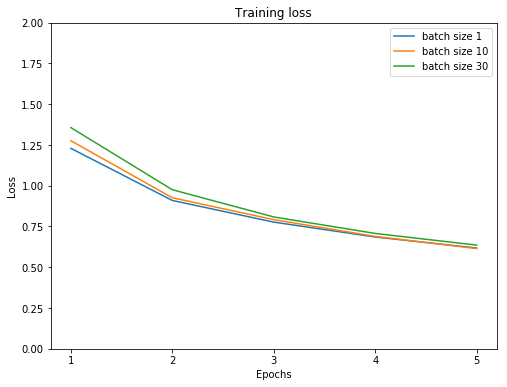

In [18]:
fig,ax = plt.subplots(figsize=(8,6))

for batch_size, (train_epoch_stats, best_epoch) in batch_results.items():
    train_loss, test_loss, test_accuracy = zip(*train_epoch_stats)
    epochs = range(1, 1+len(train_loss))
    ax.plot(epochs, train_loss, "-", label = "batch size {}".format(batch_size))
ax.set_xticks(epochs)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_ylim([0,2])
ax.set_title("Training loss")
ax.legend(loc="upper right");

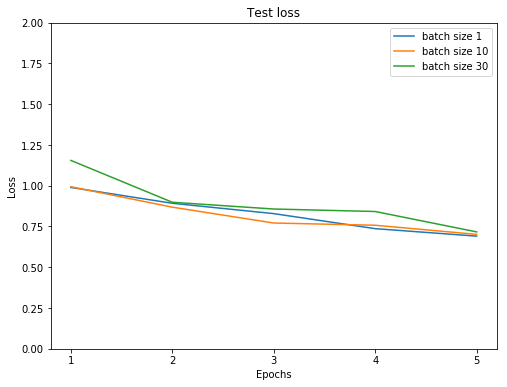

In [20]:
fig,ax = plt.subplots(figsize=(8,6))
for batch_size, (train_epoch_stats, best_epoch) in batch_results.items():
    train_loss, test_loss, test_accuracy = zip(*train_epoch_stats)
    epochs = range(1, 1+len(test_loss))
    ax.plot(epochs, test_loss, "-", label = "batch size {}".format(batch_size))
ax.set_xticks(epochs)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_ylim([0,2])
ax.set_title("Test loss")
ax.legend(loc="upper right")
plt.show()

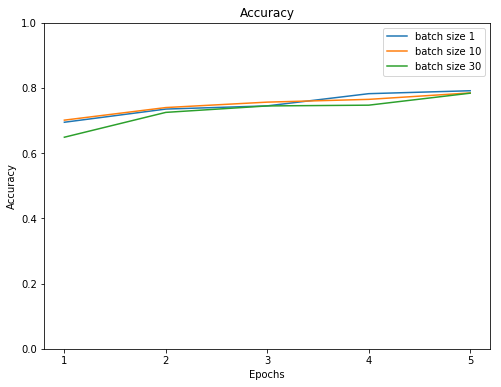

In [21]:
fig,ax = plt.subplots(figsize=(8,6))
for batch_size, (train_epoch_stats, best_epoch) in batch_results.items():
    train_loss, test_loss, test_accuracy = zip(*train_epoch_stats)
    epochs = range(1, 1+len(test_accuracy))
    ax.plot(epochs, test_accuracy, "-", label = "batch size {}".format(batch_size))
ax.set_xticks(epochs)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_ylim([0,1])
ax.set_title("Accuracy")
ax.legend(loc="upper right")
plt.show()